In [2]:
import pandas as pd
# Pour limiter les temps de calcul on travaille uniquement sur les 'nrows' premiers mails
df = pd.read_csv("/Users/franckglastre/emaildata_100000_0.csv", nrows=200)
#df = pd.read_csv("emaildata_100000_0.csv", nrows=200)
df.head()

,Unnamed: 0,date,sender,recipient1,subject,text
0,0,2001-05-14 16:39:00-07:00,phillip.allen@enron.com,tim.belden@enron.com,NaN,"['', 'Here is our forecast', '', ' ']"
1,1,2001-05-04 13:51:00-07:00,phillip.allen@enron.com,john.lavorato@enron.com,Re:,"['', 'Traveling to have a business meeting tak..."
2,2,2000-10-18 03:00:00-07:00,phillip.allen@enron.com,leah.arsdall@enron.com,Re: test,"['', 'test successful. way to go!!!']"
3,3,2000-10-23 06:13:00-07:00,phillip.allen@enron.com,randall.gay@enron.com,NaN,"['', 'Randy,', '', ' Can you send me a schedul..."
4,4,2000-08-31 05:07:00-07:00,phillip.allen@enron.com,greg.piper@enron.com,Re: Hello,"['', ""Let's shoot for Tuesday at 11:45. ""]"


In [153]:
df = df.rename(columns={'sender': 'from', 'recipient1': 'to','subject': 'header', 'text': 'body'})
df.head(5)

,Unnamed: 0,date,from,to,header,body
0,0,2001-05-14 16:39:00-07:00,phillip.allen@enron.com,tim.belden@enron.com,NaN,"['', 'Here is our forecast', '', ' ']"
1,1,2001-05-04 13:51:00-07:00,phillip.allen@enron.com,john.lavorato@enron.com,Re:,"['', 'Traveling to have a business meeting tak..."
2,2,2000-10-18 03:00:00-07:00,phillip.allen@enron.com,leah.arsdall@enron.com,Re: test,"['', 'test successful. way to go!!!']"
3,3,2000-10-23 06:13:00-07:00,phillip.allen@enron.com,randall.gay@enron.com,NaN,"['', 'Randy,', '', ' Can you send me a schedul..."
4,4,2000-08-31 05:07:00-07:00,phillip.allen@enron.com,greg.piper@enron.com,Re: Hello,"['', ""Let's shoot for Tuesday at 11:45. ""]"


In [180]:
# fonction pour sélectionner uniquement l'email principal, et éliminer les forwards suivants

def sel_email_principal(df):
    import re
    result = re.finditer(r'\'-+ Forwarded by.{,700}Subject:', df)
    # print all match object
    deb=0
    fin=0
    texte=""
    liste=[]
    for match_obj in result:
        liste.append(match_obj.span())
    if len(liste)==0:
        return df
    if len(liste)==1:
        deb=int(liste[0][0])
        fin=int(liste[0][1])
        return df[fin:]
    if len(liste)>1:
        fin=int(liste[0][1])
        deb=int(liste[1][0])
        return df[fin:deb]
    
# création d'un colonne email uniquement avec l'email principal

df['body_principal']=df['body'].apply(lambda d:sel_email_principal(d))


In [181]:
# préparation du corpus de mots avec fonction de nettoyage
# prend une string / retourne une string

import re
def data_cleanstr(string):
    r = re.compile(r'[a-zA-Z0-9.-]*@[a-zA-Z0-9.-]*')
    tok=r.sub('mail', string)
    
    r = re.compile(r"([^a-zA-Z]+)")
    tok1=r.sub(' ', tok)
    return tok1
    
    

In [182]:
# préparation fonction stopwords
# prend une string / retourne une string


def remove_stop_words(text):
    import spacy
    from spacy.lang.en.stop_words import STOP_WORDS
    stopwords=list(STOP_WORDS)
    lst=[]

    for token in text.split():
        if token.lower() not in stopwords:    #checking whether the word is not 
            lst.append(token)                    #present in the stopword list.      
            result = ' '.join(lst)
    return result

In [183]:
# tokenisation du corpus de mots, utilisation de la fonction de nettoyage et mise en minuscules
# prend retourne un dataframe / retourne une liste

def tokenize_mots(df):    
    texte=[]
    phrases=""
    from nltk.tokenize import word_tokenize

    for i in df['body_principal']:
        phrases+=i  
    a=data_cleanstr(str(phrases))
    mots=word_tokenize(a)
    mots=[i.lower() for i in mots]
    return mots

# création liste mots pour corpus
mots=tokenize_mots(df)

# création liste mots pour corpus sans Stopwords
from spacy.lang.en.stop_words import STOP_WORDS
stopwords=list(STOP_WORDS)
mots_sans=[]
for mot in mots:
    if mot not in stopwords:
        mots_sans.append(mot)
    


In [184]:
# lematisation du corpus, 2 ere ligne à réactiver si besoin
# prend une liste / retourne une liste

#import nltk
#nltk.download('wordnet')

def lematize_mots(corpus):
    from nltk.stem import WordNetLemmatizer

    # Initialiser un lemmatiseur
    wordnet_lemmatizer = WordNetLemmatizer()

    #Calculer le lemme du mot meeting
    corpus=[]
    for mot in mots_sans:
        a=""
        a=wordnet_lemmatizer.lemmatize(mot)
        corpus.append(a)
    return corpus


# création liste pour corpus
corpus=lematize_mots(mots)
corpus_sans=lematize_mots(mots_sans)

In [185]:
# vectorisation du corpus de mots
# retourne un dictionnaire

def bagofwords(corpus):
    from sklearn.feature_extraction.text import CountVectorizer

    # Créer un vectorisateur
    vectorizer = CountVectorizer()

    # Appliquer Bag of words à la variable tokens
    vectorizer.fit_transform(corpus).todense()

    # Récupération des tokens
    #tokenized = vectorizer.vocabulary_
    #token=dict(sorted(tokenized.items(),key= lambda x:x[1],reverse=True))
    #print(token)

    return vectorizer

vectorizer=bagofwords(corpus)
vectorizer_sans=bagofwords(corpus_sans)


In [186]:
# vectorisation de chaque email 1 par 1 et enregistrement dans une colonne dédiée body_vect, au passage création de body_clean

texte=[]
df['body_clean']=""
df["body_vect"]=""
df["body_vect_sans"]=""
for i,j in enumerate(df['body_principal']):
    text=data_cleanstr(str(j))
    df.loc[i,"body_clean"]=text
    df.loc[i,"body_vect"]=[vectorizer.transform([text]).toarray()]
    df.loc[i,"body_vect_sans"]=[vectorizer_sans.transform([text]).toarray()]
        
        
 
# liste contenant le corpus de mots, le premier avec les stopwords, le second sans les stopswords --> épuré des chiffres,
# et des signes de punctuations ou autres






In [187]:

df=df.dropna()
lfunc = lambda e: e[0]
df['body_vect2']=df['body_vect'].map(lambda x:lfunc(x))
df['body_vect_sans2']=df['body_vect_sans'].map(lambda x:lfunc(x))
df.head(5)

,Unnamed: 0,date,from,to,header,body,body_principal,body_clean,body_vect,body_vect_sans,body_vect2,body_vect_sans2
1,1,2001-05-04 13:51:00-07:00,phillip.allen@enron.com,john.lavorato@enron.com,Re:,"['', 'Traveling to have a business meeting tak...","['', 'Traveling to have a business meeting tak...",Traveling to have a business meeting takes th...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,2,2000-10-18 03:00:00-07:00,phillip.allen@enron.com,leah.arsdall@enron.com,Re: test,"['', 'test successful. way to go!!!']","['', 'test successful. way to go!!!']",test successful way to go,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,4,2000-08-31 05:07:00-07:00,phillip.allen@enron.com,greg.piper@enron.com,Re: Hello,"['', ""Let's shoot for Tuesday at 11:45. ""]","['', ""Let's shoot for Tuesday at 11:45. ""]",Let s shoot for Tuesday at,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5,5,2000-08-31 04:17:00-07:00,phillip.allen@enron.com,greg.piper@enron.com,Re: Hello,"['', 'Greg,', '', ' How about either next Tues...","['', 'Greg,', '', ' How about either next Tues...",Greg How about either next Tuesday or Thursda...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7,7,2000-07-14 06:59:00-07:00,phillip.allen@enron.com,joyce.teixeira@enron.com,Re: PRC review - phone calls,"['', 'any morning between 10 and 11:30']","['', 'any morning between 10 and 11:30']",any morning between and,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


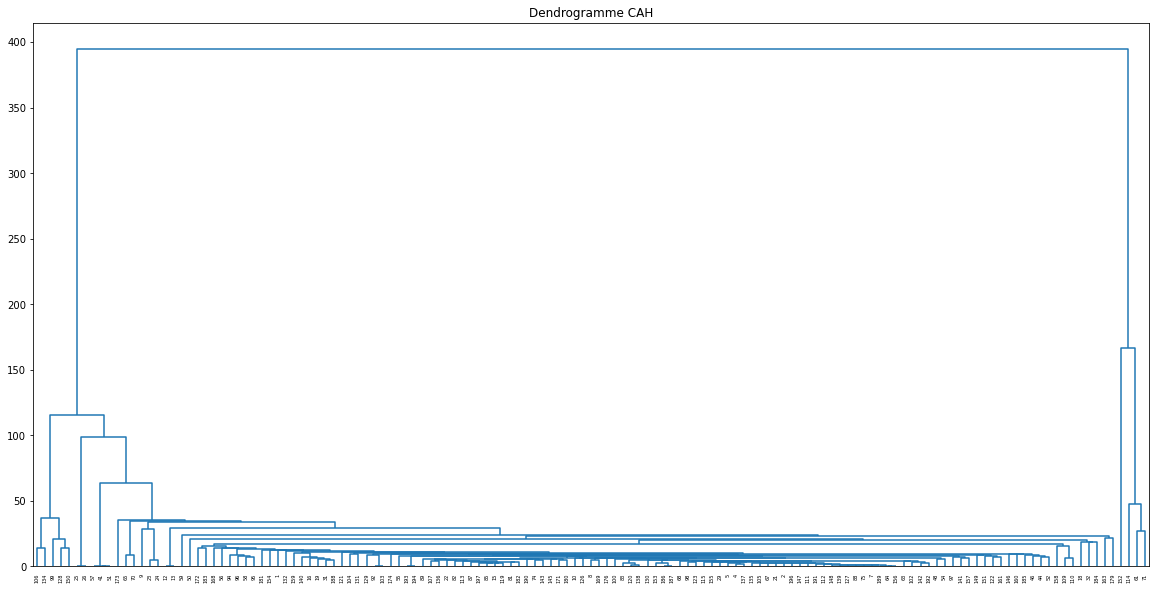

In [188]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np

# Initialisaion de la figrue
plt.figure(figsize=(20, 10))

body_linkage = np.concatenate([i.reshape((1,-1)) for i in df.body_vect2.values], axis=0)
Z = linkage(body_linkage, method = 'ward', metric = 'euclidean')


plt.title("Dendrogramme CAH")
dendrogram(Z, labels = df.index, leaf_rotation = 90., color_threshold = 0)
plt.show()

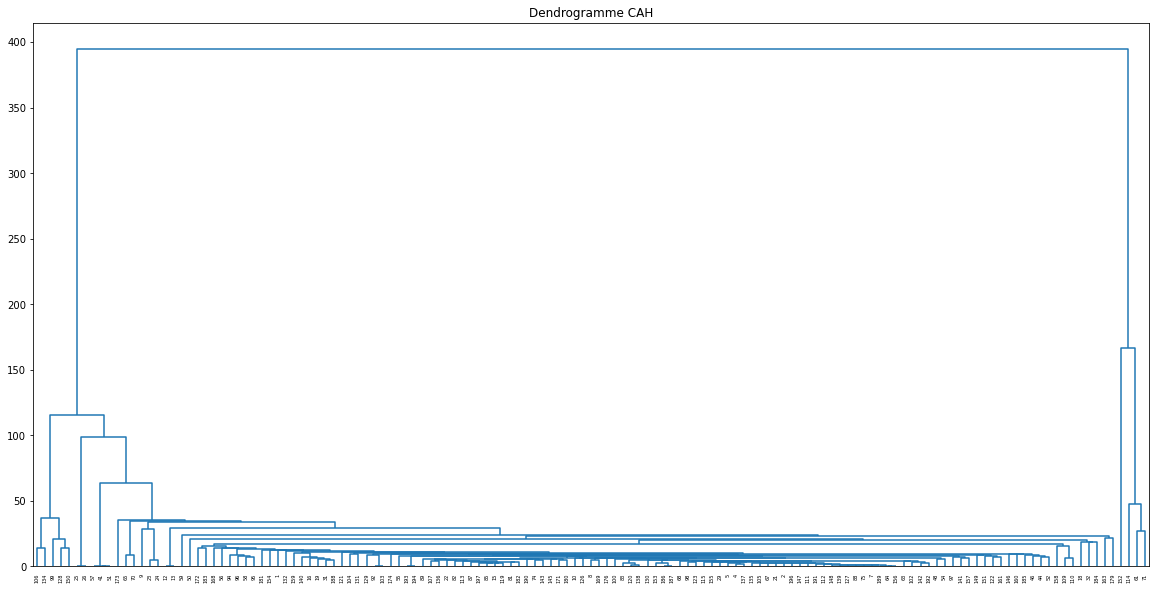

In [189]:
body_linkage_sans = np.concatenate([i.reshape((1,-1)) for i in df.body_vect_sans2.values], axis=0)
Z = linkage(body_linkage, method = 'ward', metric = 'euclidean')

plt.figure(figsize=(20, 10))
plt.title("Dendrogramme CAH")
dendrogram(Z, labels = df.index, leaf_rotation = 90., color_threshold = 0)
plt.show()

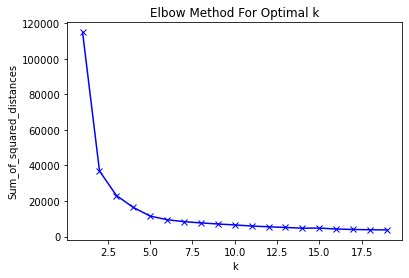

In [190]:
from sklearn.cluster import KMeans
Sum_of_squared_distances = []
K = range(1,20)
for k in K:
   km = KMeans(n_clusters=k, max_iter=200, n_init=10, random_state=0)
   km = km.fit(body_linkage)
   Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

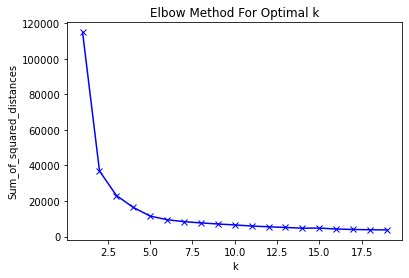

In [191]:
from sklearn.cluster import KMeans
Sum_of_squared_distances = []
K = range(1,20)
for k in K:
   km = KMeans(n_clusters=k, max_iter=200, n_init=10, random_state=0)
   km = km.fit(body_linkage_sans)
   Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [192]:
true_k = 3
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=200, n_init=10)
model.fit(body_linkage)
labels=model.labels_

print(pd.Series(labels))
print(len(df))

0      0
1      0
2      0
3      0
4      0
      ..
134    0
135    0
136    0
137    0
138    0
Length: 139, dtype: int32
139


In [193]:
true_k = 3
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=200, n_init=10)
model.fit(body_linkage_sans)
labels_sans=model.labels_

print(pd.Series(labels))
print(len(df))

0      0
1      0
2      0
3      0
4      0
      ..
134    0
135    0
136    0
137    0
138    0
Length: 139, dtype: int32
139


In [194]:
df['labels']=pd.Series(labels)
df['labels'].unique()

array([ 0.,  2., nan])

In [195]:
df['labels_sans']=pd.Series(labels_sans)
df['labels_sans'].unique()

array([ 0.,  2., nan])

In [196]:
df[df['labels']==0][['body_clean','labels']]

,body_clean,labels
1,Traveling to have a business meeting takes th...,0.0
2,test successful way to go,0.0
4,Let s shoot for Tuesday at,0.0
5,Greg How about either next Tuesday or Thursda...,0.0
7,any morning between and,0.0
...,...,...
134,Forwarded by Phillip K Allen HOU ECT on PM tE...,0.0
135,I would look at properties in San Antonio or ...,0.0
136,Celeste I need two assoc analyst for the west...,0.0
137,How about Tuesday at in front of the building,0.0


In [197]:
df[df['labels_sans']==0][['body_clean','labels_sans']]

,body_clean,labels_sans
1,Traveling to have a business meeting takes th...,0.0
2,test successful way to go,0.0
4,Let s shoot for Tuesday at,0.0
5,Greg How about either next Tuesday or Thursda...,0.0
7,any morning between and,0.0
...,...,...
134,Forwarded by Phillip K Allen HOU ECT on PM tE...,0.0
135,I would look at properties in San Antonio or ...,0.0
136,Celeste I need two assoc analyst for the west...,0.0
137,How about Tuesday at in front of the building,0.0


In [198]:
df[df['labels']==1][['body_clean','labels']]

,body_clean,labels


In [199]:
df[df['labels_sans']==1][['body_clean','labels_sans']]

,body_clean,labels_sans


In [200]:
df[df['labels']==2][['body_clean','labels']]

,body_clean,labels
103,tRequest from Steve Kean Phillip I got this r...,2.0


In [201]:
df[df['labels_sans']==2][['body_clean','labels_sans']]

,body_clean,labels_sans
103,tRequest from Steve Kean Phillip I got this r...,2.0
